# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [202]:
p_k1 = 8/10
p_k2 = 2/10

entropy = np.round(-(p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2)), 2)
entropy

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [203]:
H_m = (8/10) * (1 - 8/10) + (2/10) * (1 - 2/10)
H_l = (8/8) * (1 - 8/8)
H_r = (2/2) * (1 - 2/2)
Q = H_m - (8/10)*H_l - (2/10)*H_r
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [204]:
objects = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
predict = sum(objects)/len(objects)
predict

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [205]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [206]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if len(np.unique(feature_vector)) <= 1:
        return np.array([]), np.array([]), 0.0, 0.0

    gin = list()
    if feature_type == "real":
        sort_index = np.argsort(feature_vector)
        feature_vector = feature_vector[sort_index]
        target_vector = target_vector[sort_index]
        porog = (feature_vector[:-1] + feature_vector[1:])/2

        if task == "classification":
            for i in range(1, len(feature_vector)):
                size_l, size_r = i, len(feature_vector) - i
                prob_l, prob_r = np.bincount(target_vector[:i])/size_l, np.bincount(target_vector[i:])/size_r

                gin_l = 1 - np.sum(prob_l**2)
                gin_r = 1 - np.sum(prob_r**2)
                gin.append((size_l * gin_l + size_r * gin_r)/len(feature_vector))

        elif task == "regression":
            summ = np.cumsum(target_vector)
            summ2 = np.cumsum(target_vector**2)
            size_l = np.arange(1, len(feature_vector))
            size_r = len(feature_vector) - size_l
            
            disp_l = (summ2[:-1] - summ[:-1]**2/size_l)/size_l
            disp_r = (summ2[-1] - summ2[:-1] - (summ[-1] - summ[:-1])**2/size_r)/size_r
            gin = np.var(target_vector) - (disp_l*size_l + disp_r*size_r)/len(feature_vector)

    elif feature_type == "categorical":
        porog = feature_vector

        for i in feature_vector:
            mask = feature_vector == i
            target_l = target_vector[mask]
            target_r = target_vector[~mask]
            if len(target_l) == 0 or len(target_r) == 0:
                gin.append(-float("inf"))
                continue

            if task == "classification":
                prob_l, prob_r = np.bincount(target_l)/len(target_l), np.bincount(target_r)/len(target_r)
                gin_l, gin_r = 1-np.sum(prob_l**2), 1-np.sum(prob_r**2)
                gin.append(1 - ((len(target_l) * gin_l + len(target_r) * gin_r)/len(target_vector)))

            elif task == "regression":
                disp_l, disp_r = np.var(target_l), np.var(target_r)
                disp = np.var(target_vector)
                gin.append(disp - (disp_l*len(target_l) + disp_r*len(target_r))/len(target_vector))

    gin = np.array(gin)
    
    if len(gin) > 0 and np.max(gin) > -float("inf"):
        x = np.nanargmax(gin)
        porog_result = porog[x]
        gin_result = gin[x]
    else:
        porog_result = 0.0
        gin_result = 0.0

    return porog, gin, porog_result, gin_result

Эту функцию можно протестировать на датасете `California`.

In [207]:
from sklearn.datasets import fetch_california_housing

In [208]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [209]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [210]:
feature_vector = X[X.columns[0]].values
porog, gin, porog_result, gin_result = find_best_split(feature_vector=feature_vector, target_vector=y, task="regression", feature_type="real")

print(porog_result, gin_result)

5.03515 0.4127513862021651


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

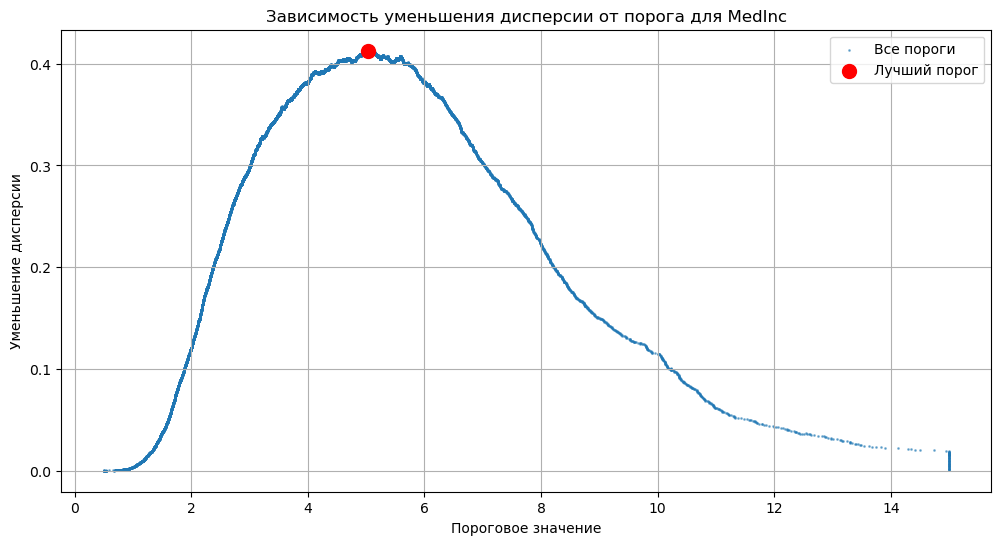

In [211]:
plt.figure(figsize=(12, 6))
plt.scatter(porog, gin, s=1, alpha=0.5, label='Все пороги')
plt.scatter(porog_result, gin_result, color='red', s=100, label='Лучший порог')
plt.title(f'Зависимость уменьшения дисперсии от порога для {X.columns[0]}')
plt.xlabel('Пороговое значение')
plt.ylabel('Уменьшение дисперсии')
plt.grid(True)
plt.legend()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [212]:
X_best = None
porog_best = None
gin_best = -float("inf")

for i in X.columns:
    porog, gin, porog_result, gin_result = find_best_split(feature_vector=X[i].values, target_vector=y, task="regression", feature_type="real")

    if gin_result > gin_best:
        X_best = i
        porog_best = porog_result
        gin_best = gin_result

X_best

'MedInc'

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [213]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {i: 0 for i in range(len(feature_types))}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # Бонус 1: игнорирует пропущенные значения при обучении,
            # а при работе на новых данных будет относить к самому популярному (по кол-ву объектов в поддереве)
            if np.sum(~np.isnan(sub_X[:, feature].astype(float))) == 0:
                continue
            
            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold
                else:
                    raise ValueError

                # Бонус 2: будем считать важность признаков по влиянию на gini
                self._feature_importances[feature] += gini

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        f_type = self._feature_types[node["feature_split"]]
        
        # Бонус 1: при получении пропуска - отправляем в самое частое поддерево
        if np.isnan(x[node["feature_split"]]):
            left_count = node.get("left_count", 0)
            right_count = node.get("right_count", 0)
            if left_count > right_count:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        
        if f_type == "real":
            if x[node["feature_split"]] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif f_type == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

    # Бонус 2: метод получения важности признаков
    def feature_importances(self):
        return self._feature_importances

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

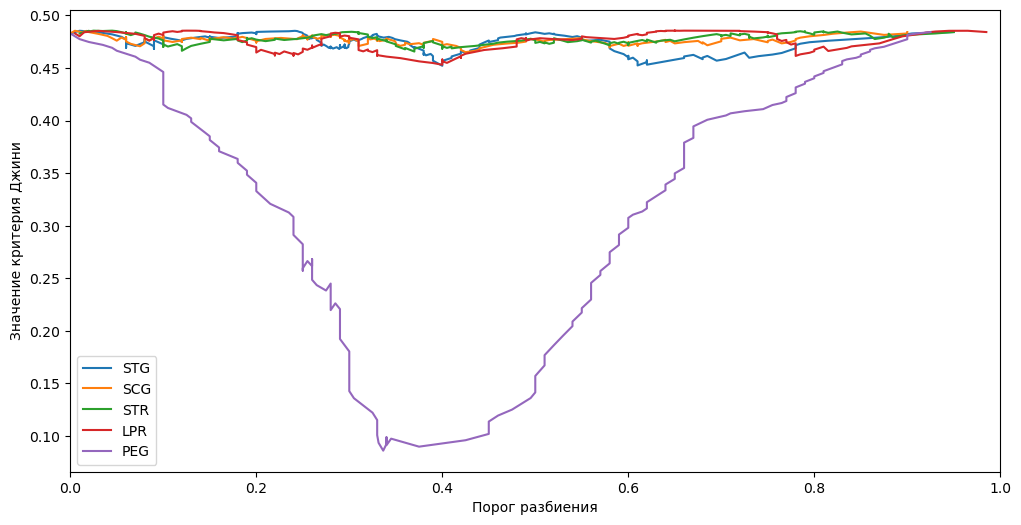

In [214]:
df = pd.read_csv("students.csv")
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]
plt.figure(figsize=(12, 6))


for i, feature in enumerate(X.columns):
    thresholds, ginis, _, _ = find_best_split(X[feature].values, y.values, task="classification", feature_type="real")
    plt.plot(thresholds, ginis, label=feature)

plt.xlim(0, 1)
plt.xlabel("Порог разбиения")
plt.ylabel("Значение критерия Джини")
plt.legend()
plt.show()

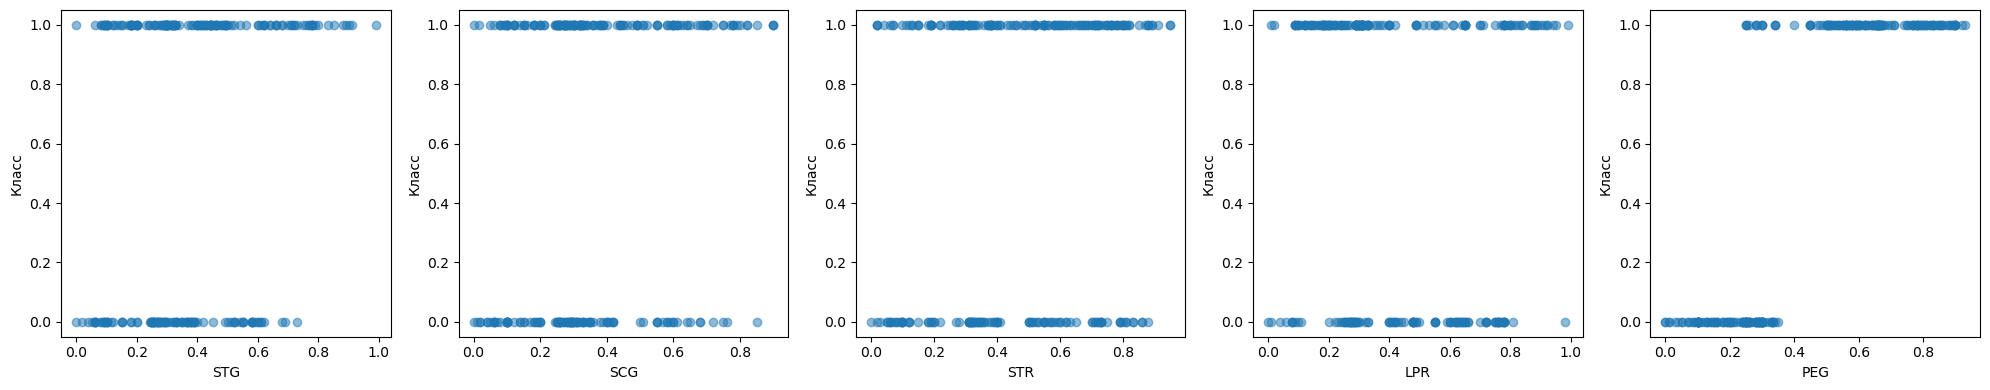

In [215]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, feature in enumerate(X.columns):
    axes[i].scatter(X[feature], y, alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Класс")

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [216]:
# Лучший признак для деления - PEG, так как на графике значений критерия Джини,
# он показывает наибольший спад в середине порога, а чем меньше значение Джини
# после разбиения - тем лучше этот признак делит классы

# Это идеально согласуется с визуальной оценкой диаграм рассеивания
# Во всех остальных классах нет прямой связи между разными пороговыми значениями и классами
# А PEG почти идеально делит классы на пороговом значении 0.4

# Вид кривой для хороших признаков - резкий уход вниз при переходе определенного порога
# а затем возвращение на место. Это говорит о том, что классы делятся четко по этому порогу

# Если кривая держится на высоких значениях и не снижается при движении порога
# Это говорит о том, что невозможно найти хороший порог и разделить классы

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (находится в директории с ноутбуком), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [218]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("agaricus-lepiota.data")
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

encoder = LabelEncoder()
for i in X.columns:
    X.loc[:, i] = encoder.fit_transform(X[i])

y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11)

tree = DecisionTree(feature_types=["categorical"] * X.shape[1], task="classification")
tree.fit(X_train.values, y_train)

y_pred = tree.predict(X_test.values)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.999507631708518

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [219]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [220]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

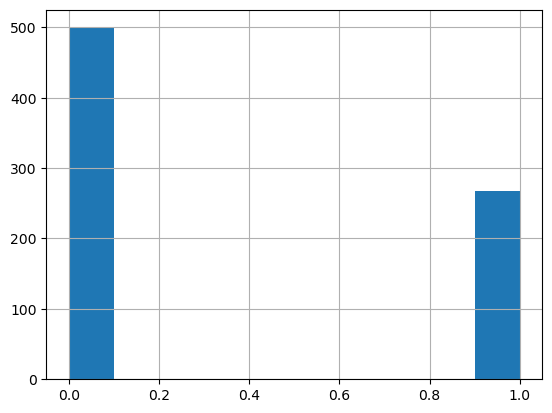

In [221]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [222]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [223]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score


max_depths = [1, 3, 5, 8, 10, 15]
min_samples_leafs = [1, 3, 5, 8, 10, 15]

best_f1 = 0
best_depth = 0
best_sample_leaf = 0

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        tree.fit(X_train_train, y_train_train)
        y_val_pred = tree.predict(X_val)
        
        current_f1 = f1_score(y_val, y_val_pred)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_depth = max_depth
            best_sample_leaf = min_samples_leaf

best_f1

0.6607142857142857

In [224]:
tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_sample_leaf)
tree.fit(X_train, y_train)

y_test_pred = tree.predict(X_test)
y_test_proba = tree.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(accuracy, precision, recall, roc_auc)

0.7792207792207793 0.660377358490566 0.5147058823529411 0.8410321183688199


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [234]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_sample_leaf),
    n_estimators=50,
)

bagging.fit(X_train, y_train)

y_test_pred = bagging.predict(X_test)
y_test_proba = bagging.predict_proba(X_test)[:, 1]

x = accuracy_score(y_test, y_test_pred)
print(x)
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_proba))

0.8225108225108225
0.7288135593220338
0.6323529411764706
0.8871346084446049


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [235]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params = {'max_depth': [1, 3, 5, 8, 10, 15, 20],
          'min_samples_split': [3, 5, 8, 10, 15, 20]}

cv = StratifiedKFold(n_splits=5, shuffle=True)
rf = RandomForestClassifier(n_estimators=50)

grid = GridSearchCV(estimator=rf, param_grid=params, cv=cv, scoring='f1')
grid.fit(X_train, y_train)
best_rf = RandomForestClassifier(n_estimators=50, max_depth=grid.best_params_['max_depth'], min_samples_split=grid.best_params_['min_samples_split'])
best_rf.fit(X_train, y_train)

y_test_pred_rf = best_rf.predict(X_test)
y_test_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print('Decision Tree', accuracy)
print('Bagging', x)
print('Random Forest', accuracy_score(y_test, y_test_pred_rf))

Decision Tree 0.7792207792207793
Bagging 0.8225108225108225
Random Forest 0.8268398268398268


In [229]:
# Лучшая модель - Random Forest

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

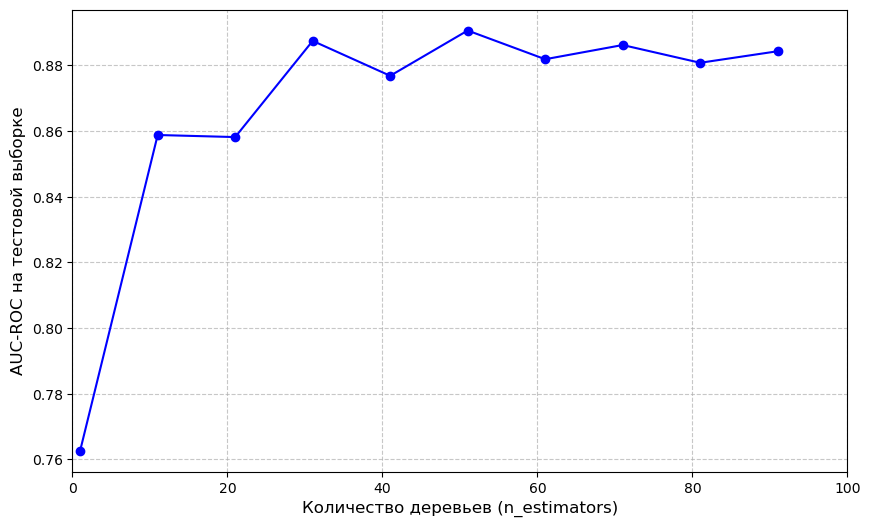

In [230]:
params = grid.best_params_

n_trees_range = np.arange(1, 101, 10)
auc_scores = []

for n in n_trees_range:
    model = RandomForestClassifier(
        n_estimators=n,
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, auc_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Количество деревьев (n_estimators)', fontsize=12)
plt.ylabel('AUC-ROC на тестовой выборке', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 201, 20))
plt.xlim(0, 100)
plt.show()

In [232]:
# AUC-ROC сильно увеличивается при n_estimators->40, но после этого выходит на плато
# Дальнейшее увеличение не принесет результата

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

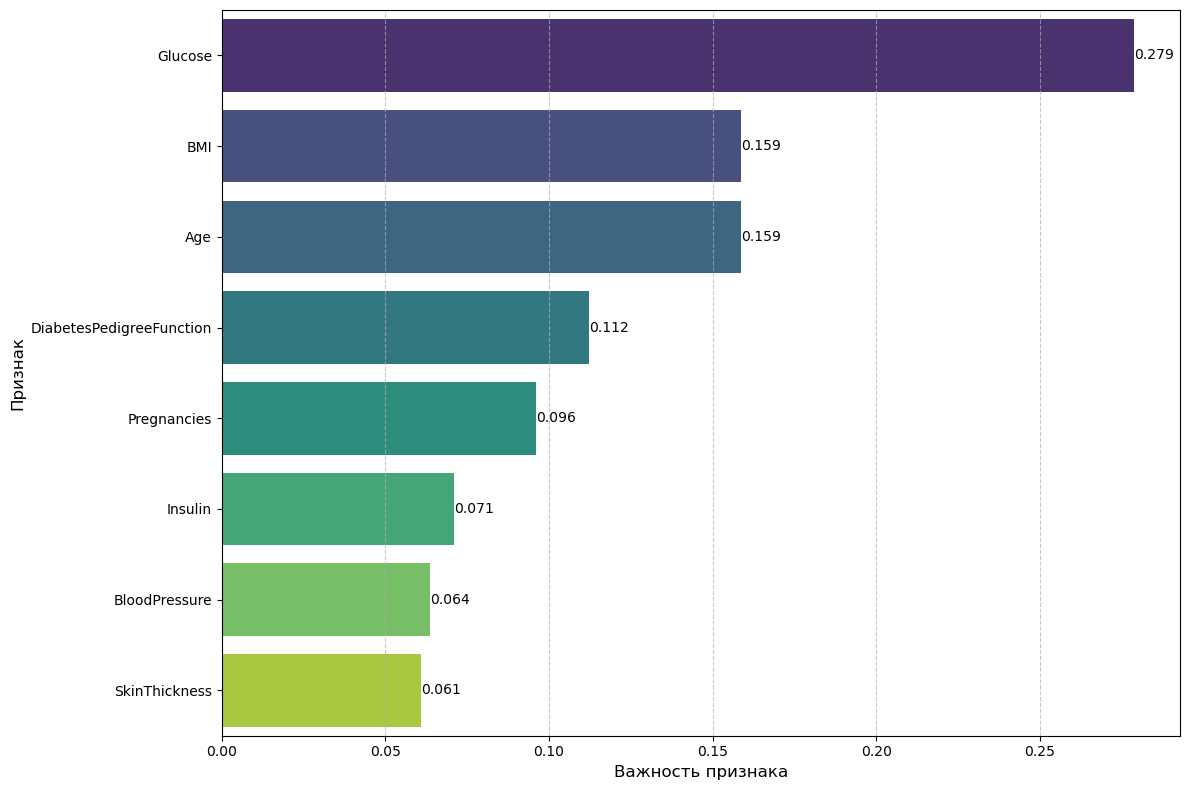

'Glucose'

In [240]:
import seaborn as sns

feature_importances = best_rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis', hue='Feature')
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for index, value in enumerate(features_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.tight_layout()
plt.show()

features_df.iloc[0]['Feature']

In [241]:
# Самый важный признак - Glucose, что в принципе ожидаемо